# OncoKB Annotation Demo

This notebook demonstrates how to use the `export_oncokb_input` method to annotate genomic variants with OncoKB data. We'll use two different input files:

1. A VCF file with GRCh38 assembly: `subset_1k_variants_ALL.chr10.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased_vep_protein_gene_variant_class.vcf`
2. A MAF file with GRCh37 assembly: `tcga_laml.maf.gz`

The notebook will show how to load these files, annotate them with OncoKB data, and display the resulting annotations.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import requests


# Import necessary functions
from pyMut.input import read_maf, read_vcf


## Get OncoKB API Token

We need an OncoKB API token to use the annotation service. We'll try to read it from a .env file.


In [2]:
# Get the OncoKB API token
import os

def read_oncokb_token(env_path):
    """Read OncoKB API token from .env file"""
    try:
        # Try using python-dotenv if available
        from dotenv import load_dotenv
        load_dotenv(env_path)
        return os.getenv('ONCOKB_API')
    except ImportError:
        # Manual parsing if python-dotenv is not available
        if env_path.exists():
            with open(env_path, 'r') as f:
                for line in f:
                    if line.startswith('ONCOKB_API='):
                        return line.split('=', 1)[1].strip()
        return None

env_path = Path("../../../.env")
oncokb_token = read_oncokb_token(env_path)

if not oncokb_token:
    logging.warning("OncoKB API token not found. Please create a .env file with ONCOKB_API=your_token")
    # For demonstration purposes, you can enter your token manually:
    oncokb_token = input("Enter your OncoKB token: ")
else:
    logging.info("OncoKB API token loaded successfully")


2025-08-01 01:31:07,607 | INFO | root | OncoKB API token loaded successfully


## Monitor API Requests

We'll add a monkey patch to monitor API requests and responses for debugging purposes.


In [3]:
# Add a monkey patch to log API requests and responses
original_post = requests.Session.post

def logging_post(*args, **kwargs):
    logging.info(f"API Request URL: {args[1]}")
    response = original_post(*args, **kwargs)
    logging.info(f"API Response Status Code: {response.status_code}")
    return response


## Process MAF File (GRCh37)

Now, we'll load and annotate the MAF file with GRCh37 assembly.


In [4]:
# Define the path to the MAF file
maf_path = "../../../src/pyMut/data/examples/MAF/tcga_laml.maf.gz"

# Load the MAF file with assembly 37
logging.info(f"Loading MAF file: {maf_path}")
maf_py_mut = read_maf(maf_path, assembly="37")

# Display basic information about the loaded data
logging.info(f"Loaded {len(maf_py_mut.data)} variants from MAF file")
logging.info(f"Assembly: {maf_py_mut.metadata.assembly}")

# Show the first few rows of the data
print("\nSample of MAF data before annotation:")
display(maf_py_mut.data.head())


2025-08-01 01:31:07,705 | INFO | root | Loading MAF file: ../../../src/pyMut/data/examples/MAF/tcga_laml.maf.gz
2025-08-01 01:31:07,705 | INFO | pyMut.input | Starting MAF reading: ../../../src/pyMut/data/examples/MAF/tcga_laml.maf.gz
2025-08-01 01:31:07,706 | INFO | pyMut.input | Loading from cache: ../../../src/pyMut/data/examples/MAF/.pymut_cache/tcga_laml.maf_8bfbda65c4b23428.parquet
2025-08-01 01:31:07,760 | INFO | pyMut.input | Cache loaded successfully in 0.05 seconds
2025-08-01 01:31:07,760 | INFO | root | Loaded 2091 variants from MAF file
2025-08-01 01:31:07,761 | INFO | root | Assembly: 37



Sample of MAF data before annotation:


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,TCGA-AB-2988,TCGA-AB-2869,TCGA-AB-3009,...,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Protein_Change,i_TumorVAF_WU,i_transcript_name
0,chr9,100077177,.,T,C,.,.,T|T,T|T,T|T,...,+,SILENT,SNP,T,T,C,TCGA-AB-2886,p.T431T,9.76,NM_020893.1
1,chr9,100085148,.,G,A,.,.,G|G,G|G,G|G,...,+,MISSENSE_MUTATION,SNP,G,G,A,TCGA-AB-2917,p.R581H,18.4,NM_020893.1
2,chr9,100971322,.,A,C,.,.,A|A,A|A,A|A,...,+,MISSENSE_MUTATION,SNP,A,A,C,TCGA-AB-2841,p.L593R,45.83,NM_018421.3
3,chr9,104086335,.,C,T,.,.,C|C,C|C,C|C,...,+,MISSENSE_MUTATION,SNP,C,C,T,TCGA-AB-2877,p.T325I,37.12,NM_017753.2
4,chr9,104124840,.,G,A,.,.,G|A,G|G,G|G,...,+,MISSENSE_MUTATION,SNP,G,G,A,TCGA-AB-2988,p.T376M,48.35,NM_001701.1


### Annotate MAF data with OncoKB


In [5]:
# Annotate the MAF data with OncoKB
if oncokb_token:
    logging.info("Annotating MAF data with OncoKB...")
    try:
        # Apply the monitoring patch
        requests.Session.post = logging_post
        
        # Perform the annotation
        maf_annotated_data = maf_py_mut.actionable_mutations_oncokb(
            token=oncokb_token,
            batch_size=1000,
            timeout=30,
            max_retries=3,
            retry_backoff=1.0
        )
        
        # Restore the original post method
        requests.Session.post = original_post
        
        # Show the first few rows of the annotated data
        print("\nSample of MAF data after annotation:")
        display(maf_py_mut.data.head())
        
        # Show annotation statistics
        def show_annotation_stats(py_mut_obj, dataset_name):
            """Show basic annotation statistics"""
            oncokb_columns = [col for col in py_mut_obj.data.columns if col.startswith('oncokb_')]
            if oncokb_columns:
                print(f"\n{dataset_name} - OncoKB annotation statistics:")
                for col in oncokb_columns:
                    non_null_count = py_mut_obj.data[col].notna().sum()
                    print(f"  {col}: {non_null_count} variants")
            else:
                print(f"\n{dataset_name} - No OncoKB annotations found")
        
        show_annotation_stats(maf_py_mut, "MAF File (GRCh37)")
        
    except Exception as e:
        logging.error(f"Error during OncoKB annotation for MAF: {e}")
        # Restore the original post method
        requests.Session.post = original_post
else:
    logging.error("Cannot perform annotation without a valid OncoKB token")


2025-08-01 01:31:07,799 | INFO | root | Annotating MAF data with OncoKB...
2025-08-01 01:31:07,800 | INFO | pyMut.annotate.actionable_mutation | Using reference genome: GRCh37
2025-08-01 01:31:07,804 | INFO | pyMut.annotate.actionable_mutation | Splitting 2091 variants into 3 batches of max 1000 variants each
/home/luisruimore/anaconda3/envs/PyMutTFG/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
2025-08-01 01:31:07,809 | INFO | pyMut.annotate.actionable_mutation | Processing batch 1/3 with 697 variants
2025-08-01 01:31:07,845 | INFO | pyMut.annotate.actionable_mutation | Sending batch 1/3 to OncoKB API
2025-08-01 01:31:07,846 | INFO | root | API Request URL: https://www.oncokb.org/api/v1/annotate/mutations/byGenomicChange
2025-08-01 01:31:11,811 | INFO | root | API Response Status Code: 200
2025-08-01 01:31:11,81


Sample of MAF data after annotation:


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,TCGA-AB-2988,TCGA-AB-2869,TCGA-AB-3009,...,oncokb_variantSummary,oncokb_tumorTypeSummary,oncokb_prognosticSummary,oncokb_diagnosticSummary,oncokb_diagnosticImplications,oncokb_prognosticImplications,oncokb_treatments,oncokb_dataVersion,oncokb_lastUpdate,oncokb_vus
0,chr9,100077177,.,T,C,.,.,T|T,T|T,T|T,...,,,,,[],[],[],v5.0,07/28/2025,False
1,chr9,100085148,.,G,A,.,.,G|G,G|G,G|G,...,,,,,[],[],[],v5.0,07/28/2025,False
2,chr9,100971322,.,A,C,.,.,A|A,A|A,A|A,...,,,,,[],[],[],v5.0,07/28/2025,False
3,chr9,104086335,.,C,T,.,.,C|C,C|C,C|C,...,,,,,[],[],[],v5.0,07/28/2025,False
4,chr9,104124840,.,G,A,.,.,G|A,G|G,G|G,...,,,,,[],[],[],v5.0,07/28/2025,False



MAF File (GRCh37) - OncoKB annotation statistics:
  oncokb_highestSensitiveLevel: 76 variants
  oncokb_highestResistanceLevel: 15 variants
  oncokb_highestDiagnosticImplicationLevel: 177 variants
  oncokb_highestPrognosticImplicationLevel: 119 variants
  oncokb_otherSignificantSensitiveLevels: 2091 variants
  oncokb_otherSignificantResistanceLevels: 2091 variants
  oncokb_hotspot: 2091 variants
  oncokb_geneSummary: 2091 variants
  oncokb_variantSummary: 2091 variants
  oncokb_tumorTypeSummary: 2091 variants
  oncokb_prognosticSummary: 2091 variants
  oncokb_diagnosticSummary: 2091 variants
  oncokb_diagnosticImplications: 2091 variants
  oncokb_prognosticImplications: 2091 variants
  oncokb_treatments: 2091 variants
  oncokb_dataVersion: 2091 variants
  oncokb_lastUpdate: 2091 variants
  oncokb_vus: 2091 variants


## Conclusion

This notebook has demonstrated how to use the OncoKB annotation functionality to annotate genomic variants from a MAF file.



CONCLUSION
Final OncoKB annotation results for MAF file:


,MAF (GRCh37)
Sensitivity,76
Resistance,15
Diagnostic,177
Prognostic,119
Hotspot,91
VUS,25


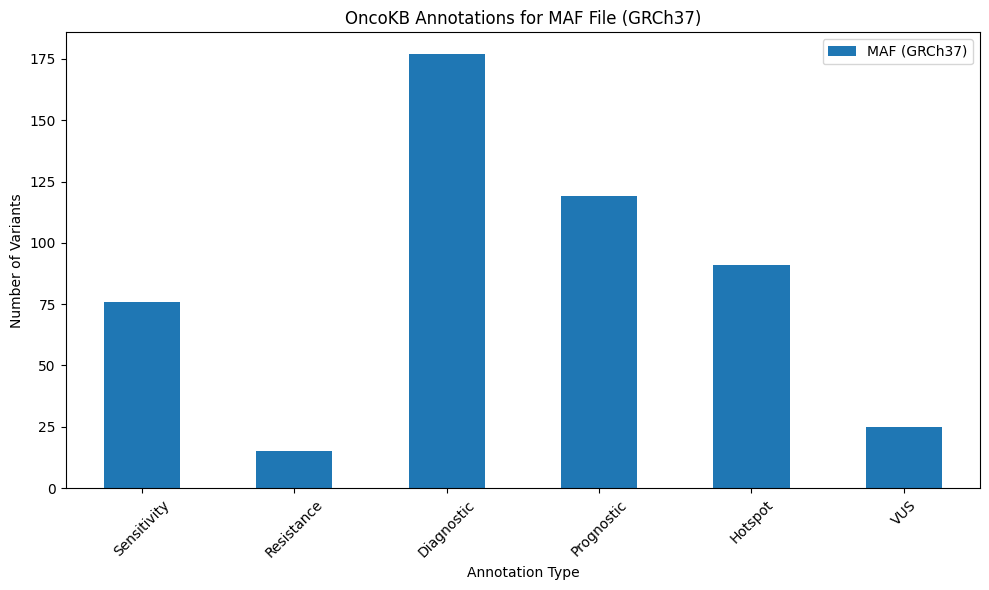


Annotation rate: 207/2091 variants annotated (9.90%)

SUMMARY:
This notebook successfully demonstrated how to:
1. Load OncoKB API token from .env file
2. Load a MAF file with GRCh37 assembly
3. Annotate variants with OncoKB actionable mutation data
4. Display annotation statistics and results

The OncoKB annotations provide valuable information about the clinical actionability of variants.


In [6]:
print("\n" + "=" * 80)
print("CONCLUSION")
print("=" * 80)

# Check if the MAF dataset was annotated
maf_oncokb_columns = [col for col in maf_py_mut.data.columns if col.startswith('oncokb_')]

if maf_oncokb_columns:
    # Show final annotation statistics
    maf_annotation_counts = {
        'Sensitivity': maf_py_mut.data['oncokb_highestSensitiveLevel'].notna().sum() if 'oncokb_highestSensitiveLevel' in maf_py_mut.data.columns else 0,
        'Resistance': maf_py_mut.data['oncokb_highestResistanceLevel'].notna().sum() if 'oncokb_highestResistanceLevel' in maf_py_mut.data.columns else 0,
        'Diagnostic': maf_py_mut.data['oncokb_highestDiagnosticImplicationLevel'].notna().sum() if 'oncokb_highestDiagnosticImplicationLevel' in maf_py_mut.data.columns else 0,
        'Prognostic': maf_py_mut.data['oncokb_highestPrognosticImplicationLevel'].notna().sum() if 'oncokb_highestPrognosticImplicationLevel' in maf_py_mut.data.columns else 0,
        'Hotspot': maf_py_mut.data['oncokb_hotspot'].sum() if 'oncokb_hotspot' in maf_py_mut.data.columns else 0,
        'VUS': maf_py_mut.data['oncokb_vus'].sum() if 'oncokb_vus' in maf_py_mut.data.columns else 0
    }
    
    # Create a DataFrame for final results
    results_df = pd.DataFrame({
        'MAF (GRCh37)': maf_annotation_counts
    })
    
    print("Final OncoKB annotation results for MAF file:")
    display(results_df)
    
    # Visualize results
    results_df.plot(kind='bar', figsize=(10, 6))
    plt.title('OncoKB Annotations for MAF File (GRCh37)')
    plt.xlabel('Annotation Type')
    plt.ylabel('Number of Variants')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate annotation rate
    maf_total = len(maf_py_mut.data)
    maf_annotated = maf_py_mut.data[maf_py_mut.data['oncokb_highestSensitiveLevel'].notna() | 
                                    maf_py_mut.data['oncokb_highestResistanceLevel'].notna() | 
                                    maf_py_mut.data['oncokb_highestDiagnosticImplicationLevel'].notna() | 
                                    maf_py_mut.data['oncokb_highestPrognosticImplicationLevel'].notna()].shape[0] if all(col in maf_py_mut.data.columns for col in ['oncokb_highestSensitiveLevel', 'oncokb_highestResistanceLevel', 'oncokb_highestDiagnosticImplicationLevel', 'oncokb_highestPrognosticImplicationLevel']) else 0
    
    print(f"\nAnnotation rate: {maf_annotated}/{maf_total} variants annotated ({maf_annotated/maf_total*100:.2f}%)")
    
    print("\nSUMMARY:")
    print("This notebook successfully demonstrated how to:")
    print("1. Load OncoKB API token from .env file")
    print("2. Load a MAF file with GRCh37 assembly")
    print("3. Annotate variants with OncoKB actionable mutation data")
    print("4. Display annotation statistics and results")
    print("\nThe OncoKB annotations provide valuable information about the clinical actionability of variants.")
else:
    print("MAF dataset was not annotated successfully. Please check your OncoKB API token and try again.")